In [45]:
%reset -f

In [97]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import pickle
sys.path.append("../utils/")

import numpy as np
import pandas as pd

from scipy.stats import pearsonr

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import LSTM, GRU
from keras.layers.wrappers import TimeDistributed
from keras import regularizers
from keras.optimizers import *

import sklearn as skl
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5.0, 4.0)

from plot_style import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read Data

In [47]:
def read_data(data_name, data_type, n_cols):
    df = pd.read_csv('data/%s_%s.txt' % (data_type, data_name), sep=' ', header=None)
    df.columns = ['uid', 'cycle'] + ['oper' + str(i+1) for i in range(3)] + ['meas' + str(i+1) for i in range(23)]
    
    assert df['uid'].min() == 1, 'uid does not start with 1'
    assert df['uid'].max() - df['uid'].min() + 1 == len(set(df['uid'])), 'Some number between uid.min and uid.max is not assigned'
    assert (df.groupby('uid')['cycle'].min() == 1).all(), 'Some uid starts with cycle > 1'
    
    return df.iloc[:, :n_cols]

dataset_name = 'FD001'
train_df = read_data(dataset_name, 'train', 26)
test_df = read_data(dataset_name, 'test', 26)

train_uid = train_df['uid']
train_cycle = train_df['cycle']
train_df = train_df.drop(['uid', 'cycle'], axis=1)

test_uid = test_df['uid']
test_cycle = test_df['cycle']
test_df = test_df.drop(['uid', 'cycle'], axis=1)

assert train_df.shape[1] == test_df.shape[1], 'Training and test datasets have different numbers of columns'

print 'Training raw data shape: ', train_df.shape
print 'Test raw data shape: ', test_df.shape

Training raw data shape:  (20631, 24)
Test raw data shape:  (13096, 24)


## Remove Redundant Features

In [48]:
def find_near_constant_columns(df, eps):
    std = df.std(axis=0)
    drop_cols = df.columns.values[std < eps]
    return drop_cols, std[drop_cols]

eps = 1e-6
rmv_cols, rmv_stds = find_near_constant_columns(train_df, eps)
train_df = train_df.drop(rmv_cols, axis=1)
test_df = test_df.drop(rmv_cols, axis=1)

print 'Removed Features with Std < %.0e: ' % eps
print pd.DataFrame([rmv_cols, rmv_stds], index=['Features', 'Std']).T
   
def find_pcc_based_removable_columns(df, th):
    """
    Remove columns that are highly correlated with some other columns kept
    """
    # pairwise correlation coefficients
    pcc = df.corr(method='pearson').values
    
    # for each i, compute L[i] = {j != i : corr(i,j) > th}, and
    # sort elements of L in thrie sizes
    L = [(r > th).nonzero()[0] for r in pcc]
    nL = [len(l) for l in L]
    nL_sort_ix = np.array(nL).argsort()[::-1]
    
    rmv_ix = []
    for i in nL_sort_ix:
        if i in rmv_ix:
            continue
        else:
            rmv_ix += L[i]
    
    return rmv_ix

th = 0.98
while True:
    rmv_ix = find_pcc_based_removable_columns(train_df, th)
    rmv_ix = [ix for ix in rmv_ix if ix > 1]
    
    if len(rmv_ix) == 0:
        break
    else:
        train_df = train_df.drop(train_df.columns[rmv_ix], axis=1)
        test_df = test_df.drop(test_df.columns[rmv_ix], axis=1)
        print 'Removed Features due to Corr. Coef. > %f: ', (train_df.columns[rmv_ix], th)

Removed Features with Std < 1e-06: 
  Features          Std
0    oper3            0
1    meas1  6.53715e-11
2    meas5   3.3947e-12
3   meas10  4.66083e-13
4   meas16  1.55643e-14
5   meas18            0
6   meas19            0


## Normalize Data

In [49]:
def normalize(df, eps):
    df_mean = df.mean(axis=0)
    df_std = df.std(axis=0)
    return (df - df_mean) / (df_std + eps), df_mean, df_std

eps = 1e-8
train_df, train_mean, train_std = normalize(train_df, eps)
test_df = (test_df - train_mean) / (train_std + eps)

## Recast Data

In [50]:
def recast_data(df, win_size, mode, many_to_many, X_flatten):
    life_cycles = df.groupby('uid')['cycle'].max()
    record_ends = life_cycles.cumsum().values
    X_raw = df.drop(['uid', 'cycle'], axis=1).values
    
    X, y = [], []
    prev_end = 0
    for i in range(df['uid'].max()):
        curr_end = record_ends[i]
        Xi_raw = X_raw[prev_end:curr_end, :]
        
        Ni = Xi_raw.shape[0]
        rul_full = np.arange(Ni)[::-1]
        if mode == 'train':
            for j in range(Ni-win_size+1):
                X.append(Xi_raw[j:j+win_size, :])
                if X_flatten:
                    X[-1] = X[-1].flatten()
                    
                if many_to_many:
                    y.append(rul_full[j:j+win_size])
                else:
                    y.append([Ni-win_size-j])
        elif mode == 'test':
            X.append(Xi_raw[Ni-win_size:, :].flatten())
        else:
            raise Exception('in recast_data, mode should be one of {train, test}')
            
        prev_end = curr_end
        
    return np.array(X), np.array(y)

## Define Models

In [51]:
def get_regression_model(input_dim, output_dim, hidden_dims, hidden_layer_param, compile_param):
    model = Sequential()
    model.add(Dense(hidden_dims[0], input_dim=input_dim, **hidden_layer_param))
    model.add(BatchNormalization())
    
    for h_dim in hidden_dims[1:]:
        model.add(Dense(h_dim, **hidden_layer_param))
        model.add(BatchNormalization())

    model.add(Dense(output_dim, kernel_initializer='normal'))
    
    model.compile(**compile_param)
    return model

## Evaluate

In [52]:
def evaluate(y_true, y_pred, classification):
    if classification:
        acc = accuracy_score(y_true, y_pred)
        pre, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', pos_label=1)

        cfs_mat = confusion_matrix(y_true, y_pred)
        fpr = 1.0 * cfs_mat[0,1] / np.sum(cfs_mat[0,:])

        return {'acc': acc, 'pre': pre, 'rec': rec, 'f1': f1, 'fpr': fpr}
    else:
        mse = np.mean((y_true - y_pred)**2)
        rmse = np.sqrt(mse)
        cos_sim = cosine_similarity(y_true.reshape(1,-1), y_pred.reshape(1,-1))[0,0]
        pcc = pearsonr(y_true, y_pred)[0]
            
        return {'mse': mse, 'rmse': rmse, 'cos_sim': cos_sim, 'pcc': pcc}

## Test Various Settings

In [53]:
class Runner:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
    def __call__(self, submission, return_train_pred=False, return_test_pred=False):
        eval_trn, eval_tst = [], []
        for i, (model, param) in enumerate(submission):
            model.fit(self.X_train, self.y_train, **param)

            y_train_pred = model.fit(self.X_train)
            y_test_pred = model.fit(self.X_test)

            ev_trn = evaluate(self.y_train, y_train_pred, classification=False)
            ev_tst = evaluate(self.y_test, y_test_pred, classification=False)

            eval_trn.append(ev_trn)
            eval_tst.append(ev_tst)
        
        return_tuple = [np.array(eval_trn), np.array(eval_tst)]
        if return_train_pred:
            return_tuple.append(train_pred)
        if return_test_pred:
            return_tuple.append(test_pred)
        
        return tuple(return_tuple)

## Visualize

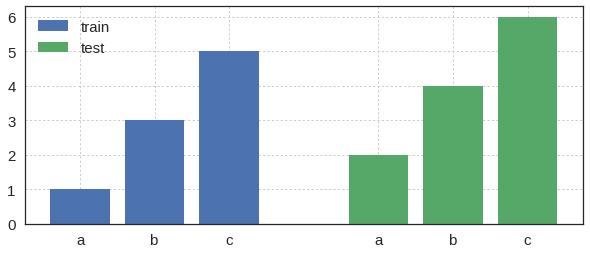

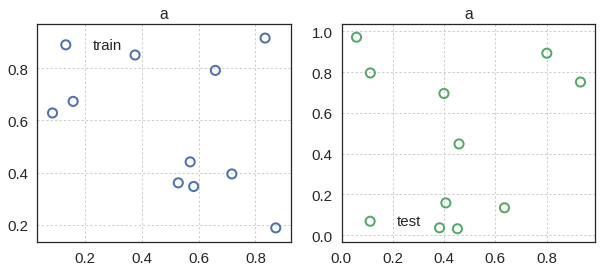

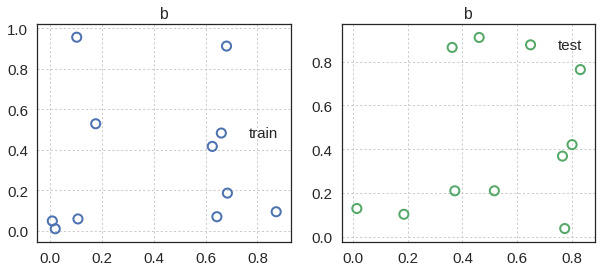

In [116]:
def plot_by_bar(result, labels):
    """
    result is assumed of the shape (M, 2) where
    - M is the number of models tested.
    result[:,0] is for training and result[:,1] for testing
    """
    result = np.arange(6).reshape(3,2) + 1
    labels = ['a','b','c']
    
    n_models = result.shape[0]
    x_range_base = np.arange(n_models)
    
    x_range = np.array([x_range_base, x_range_base + n_models + 1])
    ax = plt.bar(x_range[0], result[:, 0], label='train')
    ax = plt.bar(x_range[1], result[:, 1], label='test')
    
    plt.axes().set_xticks(x_range.flatten())
    plt.axes().set_xticklabels(labels * 2)
    
    plt.legend()
plot_by_bar(None, None)

def plot_by_scatter(y_true, y_pred, labels):
    """
    Each of y_true and y_pred is assumed of the shape (2,N,M) where
    - N is the number of instances, and
    - M is the number of models
    labels has the shape of (M,)
    """
    y_true = np.random.rand(2,10,2)
    y_pred = np.random.rand(2,10,2)
    labels=['a','b']
    
    n_models = y_true.shape[2]
    cols = get_col_palette()
    
    for i in range(n_models):
        plt.figure()
        set_fig_style(10.0)
        gs = get_gridspec(1, 2, 0.2, 0.2)
        plt.subplot(gs[0])
        plt.scatter(y_true[0,:,i], y_pred[0,:,i], facecolors='none', edgecolors=cols[0], linewidth=2, label=labels[i])
        plt.legend()
        plt.title('train')
        
        plt.subplot(gs[1])
        plt.scatter(y_true[1,:,i], y_pred[1,:,i], facecolors='none', edgecolors=cols[1], linewidth=2, label=labels[i])
        plt.legend()
        plt.title('test')
plot_by_scatter(None, None, None)
    

## Prepare Settings

In [ ]:
submission_grouped = [
    [
        (RandomForestRegressor(), {}),
        (RandomForestRegressor(), {}),
        (RandomForestRegressor(), {}),
        (RandomForestRegressor(), {}),
    ],
    [
        (get_regression_model(), {}),
        (get_regression_model(), {}),
        (get_regression_model(), {}),
        (get_regression_model(), {}),
    ]
]

## Train and Evaluate

In [198]:
train_df_full = pd.concat([train_uid, train_cycle, train_df], axis=1)
test_df_full = pd.concat([test_uid, test_cycle, test_df], axis=1)

win_size = 10
X_train, y_train = recast_data(train_df_full, win_size, 'train', many_to_many=False, X_flatten=True)
X_test, _ = recast_data(test_df_full, win_size, 'test', many_to_many=False, X_flatten=True)
y_test = pd.read_csv('data/RUL_FD001.txt', header=None).values.reshape(-1)

print 'X_train, y_train: ', X_train.shape, y_train.shape
print 'X_test, y_test: ', X_test.shape, y_test.shape

input_shape, output_dim = X_train_shaped.shape[1:], y_train.shape[1]
print 'Reshaped X_train, y_train: ', X_train_shaped.shape, y_train_shaped.shape
print 'Reshaped X_test, y_test: ', X_test_shaped.shape, y_test_shaped.shape
print 'input_shape, output_dim', input_shape, output_dim
    
model = get_regression_model(
    input_dim=input_dim, 
    output_dim=output_dim, 
    hidden_dims=[h for h in np.power(2,range(3,20)) if h < input_dim][::-1],
    hidden_layer_param={
        'activation': 'relu',
        'kernel_initializer': 'normal',
        'kernel_regularizer': regularizers.l2(0.5)
    },
    compile_param={
        'loss': 'mean_squared_error', 
        'optimizer': RMSprop(lr=0.01)
    }
)
model.summary()

batch_size = 256
n_epochs = 30
verbose = 2

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=n_epochs,
                    verbose=verbose,
                    validation_data=(X_test_shaped, y_test_shaped))
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

set_fig_style()
ax = pd.DataFrame(history.history).plot()
ax.margins(0.05)

X_train, y_train:  (19731, 10, 17) (19731, 10)
X_test, y_test:  (100, 170) (100, 10)
Reshaped X_train, y_train:  (19731, 10, 17) (19731, 10, 1)
Reshaped X_test, y_test:  (100, 10, 17) (100, 10, 1)
input_shape, output_dim (10, 17) 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_45 (GRU)                 (None, 10, 12)            1080      
_________________________________________________________________
time_distributed_90 (TimeDis (None, 10, 8)             104       
_________________________________________________________________
time_distributed_91 (TimeDis (None, 10, 4)             36        
_________________________________________________________________
time_distributed_92 (TimeDis (None, 10, 1)             5         
Total params: 1,225.0
Trainable params: 1,225
Non-trainable params: 0.0
_________________________________________________________________
Train on 19731 samples, validate on

KeyboardInterrupt: 

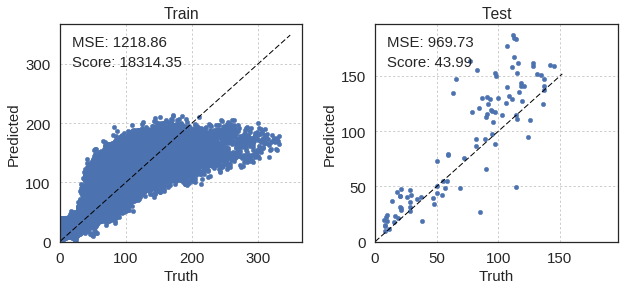

In [184]:
def asym_error(y_true, y_pred):
    d_all = y_pred.reshape(-1) - y_true.reshape(-1)
    
    coef = np.zeros_like(d_all)
    coef[d_all < 0] = -1.0/10
    coef[d_all >= 0] = 1.0/13

    return np.mean(np.exp(d_all * coef) - 1)

if with_rnn:
    y_train_last, y_train_pred_last = y_train_shaped[:, -1, 0], y_train_pred[:, -1, 0]
    y_test_last, y_test_pred_last = y_test_shaped[:, -1, 0], y_test_pred[:, -1, 0]
else:
    y_train_last, y_train_pred_last = y_train_shaped[:, -1], y_train_pred[:, -1]
    y_test_last, y_test_pred_last = y_test_shaped[:, -1], y_test_pred[:, -1]

train_mse = mean_squared_error(y_train_last, y_train_pred_last)
test_mse = mean_squared_error(y_test_last, y_test_pred_last)

train_score = asym_error(y_train_last, y_train_pred_last)
test_score = asym_error(y_test_last, y_test_pred_last)

train_acc = {'mse': train_mse, 'score': train_score}
test_acc = {'mse': test_mse, 'score': test_score}

train_result = pd.DataFrame([y_train_last, y_train_pred_last], index=['Truth', 'Predicted']).T
test_result = pd.DataFrame([y_test_last, y_test_pred_last], index=['Truth', 'Predicted']).T

set_fig_style(10, 4, 15, 15)
gs = get_gridspec(1, 2, 0.3, 0.3)
for i, res, acc, mode in zip(range(2), (train_result, test_result), (train_acc, test_acc), ('Train', 'Test')):
    ax = plt.subplot(gs[i])
    res.plot.scatter(ax=ax, x='Truth', y='Predicted', title='%s' % mode)
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', linewidth=1)
    
    y_max = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.set_xlim((0, y_max))
    ax.set_ylim((0, y_max))
    
    x_pos = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
    y_pos = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.9
    
    ax.text(x_pos, y_pos, 'MSE: %.2f' % acc['mse'], fontsize=15, horizontalalignment='left' )
    ax.text(x_pos, y_pos*0.9, 'Score: %.2f' % acc['score'], fontsize=15, horizontalalignment='left' )

In [321]:
# Training and Evaluation

def get_regression_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='tanh', kernel_initializer='normal'))
#     model.add(Dense(32, activation='tanh', kernel_initializer='normal'))
#     model.add(Dense(16, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# mini_ix = np.random.randint(X.shape[0], size=1000)
# X_mini, y_mini = X[mini_ix,:], y[mini_ix]

model_config = [
    ('kernel_svr', svm.SVR, {'kernel':'rbf'}),
    ('dnn', KerasModelWrapper, {'model_generator': get_regression_model, 'input_dim': input_dim, 'fit_param': {'batch_size':256, 'epochs':100, 'verbose':False}})
]
runner = RunnerWithBalancing(model_config)

n_splits = 10
valid_once = True
cv_obj = KFold(n_splits=n_splits, shuffle=True)
result, models, train_ix, valid_ix = runner.run(X=X, y=y, cv_obj=cv_obj, valid_once=valid_once, classification=False, verbose=False)

Model Shape:  (1, 2, 1)


ValueError: Shape of passed values is (1, 2), indices imply (2, 2)

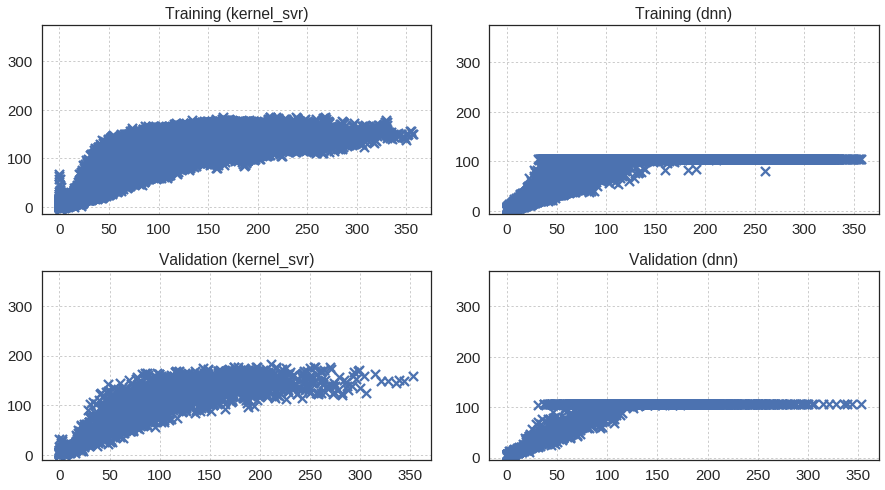

In [318]:
print 'Model Shape: ', models.shape

metrics = ['rmse', 'cos_sim']

res_val = np.empty(result.shape[1:], dtype='object')
res_trn = np.empty(result.shape[1:], dtype='object')
for i in range(result.shape[1]):
    for j in range(result.shape[2]):
        res_trn[i,j] = [result[0,i,j]['trn'][m] for m in metrics]
        res_val[i,j] = [result[0,i,j]['val'][m] for m in metrics]

if valid_once:
    res_trn = res_trn.reshape(-1)
    res_val = res_val.reshape(-1)
    
    X_train, y_train = X[train_ix, :], y[train_ix]
    X_valid, y_valid = X[valid_ix, :], y[valid_ix]
    
    set_fig_style(15.0, 8.0, 15, 15)
    gs = get_gridspec(2, result.shape[1], 0.15, 0.3)
    for i in range(result.shape[1]):
        y_train_pred = models[0,i,0].predict(X_train)
        y_valid_pred = models[0,i,0].predict(X_valid)
        
        fig = plt.subplot(gs[i])
        fig.scatter(y_train, y_train_pred, marker='x')
        fig.set_title('Training (%s)' % model_config[i][0])
        fig.set_ylim([None, fig.axes.get_xlim()[1]])
        
        fig = plt.subplot(gs[i+result.shape[1]])
        fig.scatter(y_valid, y_valid_pred, marker='x')
        fig.set_title('Validation (%s)' % model_config[i][0])
        fig.set_ylim([None, fig.axes.get_xlim()[1]])
    
    res_agg = pd.DataFrame(res_trn, index=metrics, columns=[mc[0] for mc in model_config]).T
    res_agg.plot.bar()
        
else:
    def plot_error_over_cv(res, title):
        markers = get_markers()
        for i in range(result.shape[1]):
            plt.plot(res[0,i,:], marker=markers[i], label=model_config[i][0])
        plt.title(title)
        plt.legend()

    set_fig_style(10.0, 4.0, 15, 15)
    plt.subplot(1,2,1)
    plot_error_over_cv(res_trn, 'Training')
    plt.subplot(1,2,2)
    plot_error_over_cv(res_val, 'Validation')

In [320]:
pd.DataFrame(res_trn).T

,0,1
0,"[41.1120832487, [[0.947107705543]]]","[79.8365098094, [[0.935535439762]]]"
